# Fish Classifier 🐡🐠🐟🦐

## Introduction

The goal of this work is to explore different machine learning algortihms in order to classify a set of fishes into 9 different species. The dataset has been taken from 

https://www.kaggle.com/crowww/a-large-scale-fish-dataset

In order to be able to execute this notebook download the dataset and save it in the same folder of the notebook. 

The dataset contains 9000 photos of 9 different species (1000 for each one) and has been created by O. Ulucan, D. Karakaya, M. Turkan.

The 9 different species are: gilt head bream (orata), red sea bream (orata rossa), sea bass (spigola), red mullet (triglia), horse mackerel (sugarello), black sea sprat (spratto del Mar Nero), striped red mullet (triglia di scoglio), trout (trota) and shrimp (gamberetto).

In this work we will use different machine learning techniques in order to classifiy the fishes. In particoular we will use
- Convolutional neural network
- PCA (Principal component analysis) + Feed forward neural network
- PCA + Decisional Tree
- PCA + Random forest
- PCA + Linear Discriminant Analysis
- PCA + Logistic regression

For each method we will explain briefly the underlying principles, if the methods require some parameters we will explain why we made that particoular choice and in the end we will compare all the results.

In the notebook we will make use of different Python libraries in order to speed up the implementations of all the different methods.

In [17]:
# General libraries
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

# Machine learning librarie
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras import layers, optimizers, models
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

# In order to avoid some warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

## Import Dataset

First of all we need to import the dataset. Then we will divide it into 3 different parts: the training data (60%), the validation data (25%) and the test data (15%).

The training data will be used to fit the different models, the validation data will be used in Neural networks algorithms to give an estimate of model skill while tuning model’s hyperparameters and the test data will be used to evaluate the performance of the models once the trining phase has been completed.

In [6]:
image_dir = Path('./archive/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepaths').astype(str)
labels = pd.Series(labels, name='Labels')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head()

,Filepaths,Labels
0,archive/Fish_Dataset/Fish_Dataset/Red Mullet/0...,Red Mullet
1,archive/Fish_Dataset/Fish_Dataset/Striped Red ...,Striped Red Mullet
2,archive/Fish_Dataset/Fish_Dataset/Hourse Macke...,Hourse Mackerel
3,archive/Fish_Dataset/Fish_Dataset/Trout/00095.png,Trout
4,archive/Fish_Dataset/Fish_Dataset/Hourse Macke...,Hourse Mackerel


Here there are some examples of images. Note that the images are rotated. This is a techinique used by the authors of the dataset to add data to the dataset, and also to add variance, in this way the NN will be able to recognise the fish even if it not horizontal.

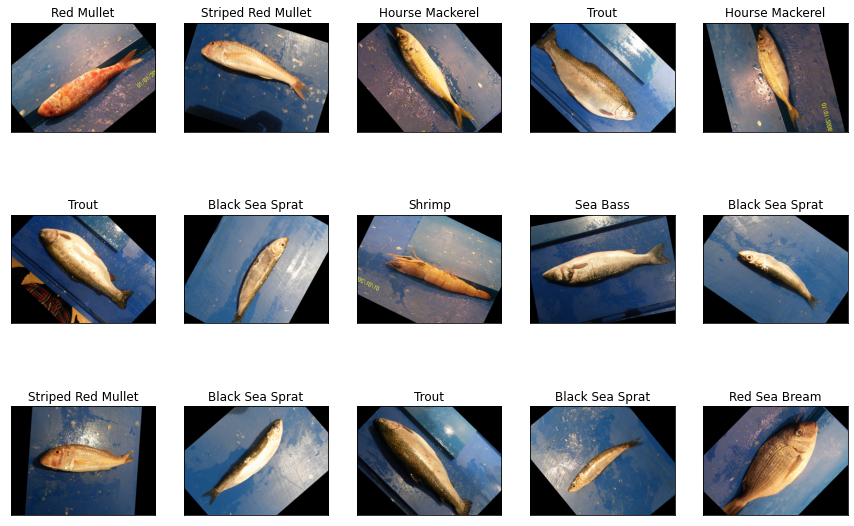

In [7]:
#Displaying a subsample of the dataset
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepaths[i]))
    ax.set_title(image_df.Labels[i])
    
plt.show()

Now I separate in train and test data

In [55]:
train_df, test_df = train_test_split(image_df, train_size=0.75, shuffle=True, random_state=1)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.20
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 5400 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 2250 validated image filenames belonging to 9 classes.


## Convolutional Neural Network 🧠

Convolutional Neaural networks (from now on CNNs) are a set of neural networks which are really good in recognising images. This is because they use a particoular operation called convolution that relates data close to each other (when the input data are in a matrix or tensorial form). In fact in an image the information contained in a single pixel is, very likely, related to its nearest neighbours and hence it is not necessary to process all the pixels but only the most significant ones.

In particoular suppose we have an input data in matrix form $S(i,j)$ then the convolution operation is performed as follow

$$
\sum_{m,n=-2}^{+2} S(i-m,j-n) w(m,n)
$$

where $w(m,n)$ is a matrix whose entrances need to be determined by minimizing the cost function. After the convolution the input matrix is activated, i.e. it is passed through a non-linear activation function (sigmoid, hyperbolic tangent, ecc...) and in the end a pooling operation is performed, that is we take 4 nearest pixels and reduce them to 1, for example taking the average (Average Pooling) or the maximum value (Max Pooling). 

This set of operations (convolution, activation and pooling) may be repeated multiple times, and goal of this first phase is to compress the information to just a few pixels. 

<u>*Example*</u>
The images in the fish dataset have 224x224 pixels (x3 colors). So the input data is a tensor whose shape is (224, 224, 3). Performing a convolution we reduce it to (222, 222, 9). The width and heigth of the image get reduced because boundary pixels cannot be related to theirs neighbours since they have not. And the number of layers increases because we apply 3 different convolution for every colour. By performing the pooling the shape changes to (111, 111, 9), so just with this first step we reduced the number of inputs from $224*224*3=150 528$ to $111*111*9=110 889$.

After repeating this process a few times we flatten the residual matrix and use it as an input of a feed forward neural network.

In [11]:
def CreateCNN(lmbd = 0.0, eta = 0.001):
    input_shape = (224, 224, 3)
    model = tf.keras.models.Sequential(name="FishCNN")

    model.add(tf.keras.layers.Conv2D(9, (3,3), activation='elu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
    model.add(tf.keras.layers.Conv2D(18, (3,3), activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
    model.add(tf.keras.layers.Conv2D(24, (3,3), activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.Dense(128, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.Dense(128, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(9, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))

    model.compile(optimizer=Adam(learning_rate=eta), loss='categorical_crossentropy', metrics=["accuracy"])
    return model

### Parameters

The full NN needs some external parameters that need to be tuned in order to perform better. In particoular I decided to tune two different parameters: the learing rate $\eta$ and the regularization parameter $\lambda$.

The learning rate controls how fast the parameters of the NN change during the training of the model. 

$$
\theta^{(n+1)}_r \longrightarrow \theta^{(n)}_r - \eta \frac{\partial \tilde{C}}{\partial \theta^{(n)}_r}
$$

The regularizion parameter modify the cost function $\tilde{C}$

$$
\tilde{C} \longrightarrow \tilde{C} + \lambda ||\vec{\theta}||_2
$$

this is useful since it bounds the maximum value of $||\vec{\theta}||_2$ and hence the parameters are limited.

In order to find the optimal choice I trained the model for just three epochs with different choice for $(\lambda,\eta)$ and in the end these are the results

<img src="optimize_lambda_eta.pdf" />

We can see that the best choice are $\lambda=10^{-5}$ and $\eta=10^{-3}$.

For activation function I chose Exponential Linear Unit, defined as follow

$$
f(x)=
\begin{cases}
x \qquad &\text{if}\quad x\ge0,\\
\alpha(e^x-1)&\text{if}\quad x<0
\end{cases}
$$

I chose this one because, in this case, it gives better results with respect to ELU, sigmoid or tanh. For the last layer, since I am facing a classification problem, where the classes are exclusive, I chose softmax

$$
f(x_i)=\frac{e^{x_i}}{\sum_k e^{x_k}}
$$

As optimizer, i.e. the algorithm to minimize the cost function, I chose ADAM.

Lastly as cost function, since this is a classification problem I chose Categorical cross entropy

$$
\tilde{C}=-\sum_{k=1}^9 y_k \log \hat y_k
$$

where $y_i$ is the real value for the class i and $\hat y_i$ the predicted one.

### Best Model

In [57]:
lmbd_best = 1e-5
eta_best = 1e-3

model = CreateCNN(lmbd=lmbd_best, eta=eta_best)

model.summary()

Model: "FishCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 9)       252       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 9)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 18)      1476      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 18)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 24)        3912      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 24)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 32)        6944

Instead of chosing in advance a certain number of epochs I decided to use the function `tf.keras.callbacks.EarlyStopping`. Thanks to this function I can monitor the cost function of the validation sample and if it does not decrease for three epochs the training process stops and restore the best set of parameters 

In [58]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3,restore_best_weights=True)

MAX_EPOCHS = 20
history = model.fit(
    train_images,
    epochs = MAX_EPOCHS,
    validation_data = val_images,
    callbacks = callback
)

Epoch 1/20
85/85 [==============================] - 182s 2s/step - loss: 1.1169 - accuracy: 0.6026 - val_loss: 0.4996 - val_accuracy: 0.8207
Epoch 2/20
85/85 [==============================] - 168s 2s/step - loss: 0.4038 - accuracy: 0.8591 - val_loss: 0.4545 - val_accuracy: 0.8630
Epoch 3/20
85/85 [==============================] - 157s 2s/step - loss: 0.1861 - accuracy: 0.9422 - val_loss: 0.2677 - val_accuracy: 0.9074
Epoch 4/20
85/85 [==============================] - 161s 2s/step - loss: 0.1649 - accuracy: 0.9469 - val_loss: 0.3024 - val_accuracy: 0.9052
Epoch 5/20
85/85 [==============================] - 149s 2s/step - loss: 0.0977 - accuracy: 0.9717 - val_loss: 0.1593 - val_accuracy: 0.9504
Epoch 6/20
85/85 [==============================] - 149s 2s/step - loss: 0.0765 - accuracy: 0.9781 - val_loss: 0.2090 - val_accuracy: 0.9407
Epoch 7/20
85/85 [==============================] - 153s 2s/step - loss: 0.0974 - accuracy: 0.9693 - val_loss: 0.1344 - val_accuracy: 0.9585
Epoch 8/20
85

Now we can evaluate the model performance looking at accuracy and loss functions and evaluating it on the test sample which has not been used yet.

[]

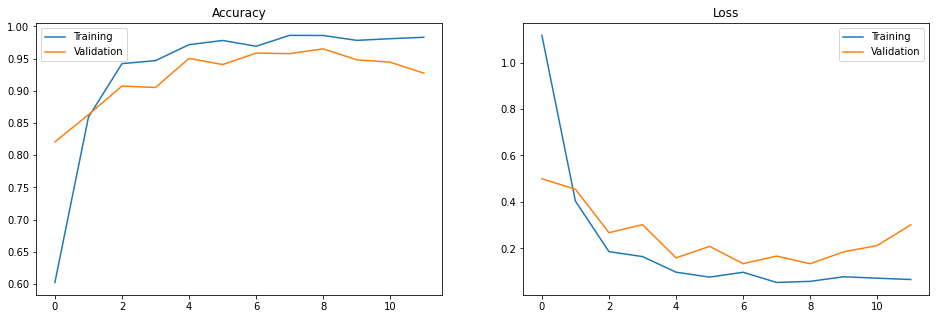

In [59]:
# Print accuracy and loss plots
_ , ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(history.history['accuracy'], label = 'Training')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].legend()
ax[1].set_title('Loss')

plt.plot()

In [63]:
# Evaluate the model on test sample
performance = model.evaluate(test_images)[1]
print(f"\nOn the test sample, the model we trained, has an accuracy of {round(performance*100,2)} %")

36/36 [==============================] - 40s 1s/step - loss: 0.0999 - accuracy: 0.9733

On the test sample, the model we trained, has an accuracy of 97.33 %


We can save the model in order to use it later

In [66]:
model.save('./fish-vfin')
# model = keras.models.load_model('./fish-vfin')

INFO:tensorflow:Assets written to: ./fish-vfin/assets


### Confusion matrix

The confusion matrix is a matrix the helps to analyze which categories are easy to recognise and which are difficult.

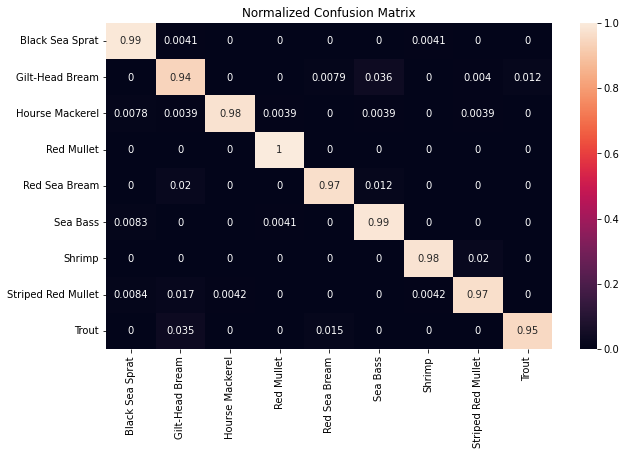

In [67]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Labels)
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

We can clearly see that the CNN has not difficoulties in recognising any particoular class, maybe only Gilt-Head Bream which is not recognised in 6% of the cases

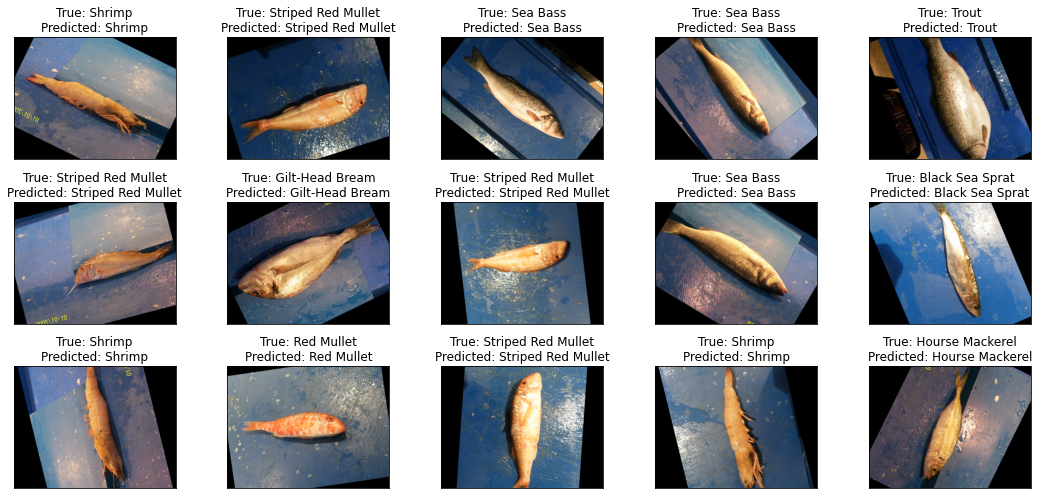

In [68]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepaths.iloc[i]))
    ax.set_title(f"True: {test_df.Labels.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

## Principal Component Analysis - Dimension reduction

The main idea behind PCA algorithm is to find the directions in the input space along which there is greater variance and project along these directions. 

For example here we have the inputs that lives in $\mathbb{R}^2$. We change the base so that the new base vectors are the direction with greatest variance, and then we project to $\mathbb{R}$ along the first PCA component.

<img src="https://blog.bioturing.com/wp-content/uploads/2018/11/Blog_pca_6b.png" width="300"/>

This idea can be generalized to higher dimension, and the method proceed as follow

We start from the design matrix

$$
X=
\begin{pmatrix}
\underline{x}_1 & \underline{x}_2 & \dots & \underline{x}_P
\end{pmatrix}
\quad \in \mathbb{R}^{NxP}
\qquad \text{with}\qquad \underline{x}_i=
\begin{pmatrix}
x_1\\
x_2\\
\dots\\
x_N
\end{pmatrix}
\quad \in \mathbb{R}^{N}
$$

We normalize it, i.e. we subtract the mean value so that $\mathbb{E}\left[\tilde X\right]=0$, where $\tilde X = X - <X>$. 

Now we can obtain the covariance matrix

$$
C\left[X\right] = 
\begin{pmatrix}
\text{var}(\underline x _1)  & \text{cov}(\underline x _1, \underline x _2) &  \dots  & \text{cov}(\underline x _1, \underline x _p)\\
\text{cov}(\underline x _2, \underline x _1) & \text{var}(\underline x _2)  &  \dots  & \text{cov}(\underline x _2, \underline x _p)\\
\dots & \dots & \dots & \dots \\
\text{cov}(\underline x _p, \underline x _1) & \text{cov}(\underline x _p, \underline x _2) & \dots & \text{var}(\underline x _p)
\end{pmatrix}
=\mathbb{E}\left[ \tilde X ^T \tilde X \right]
$$

And we diagonalize it

$$
C = V^T \Sigma V , \qquad \text{with} \quad V^T V=\mathbb{I}, \quad \Sigma=\text{diag}(\lambda_1, \dots, \lambda_P)
$$

where $\lambda_i$ are the eigenvalues of $C$, such that $\lambda_1 \ge \lambda_2 \ge \dots \ge \lambda_P$ and 

$$
V=
\begin{pmatrix}
\underline{v}_1 & \underline{v}_2 & \dots & \underline{v}_P
\end{pmatrix}
\quad \in \mathbb{R}^{NxP}
$$

with $\underline v _i$ are the eigenvectors of $C$.

In the end we choose $p<P$ and project $X$ into $\mathbb{R}^p$

$$
\tilde V=
\begin{pmatrix}
\underline{v}_1 & \underline{v}_2 & \dots & \underline{v}_p
\end{pmatrix}
\quad \in \mathbb{R}^{Nxp},
\qquad \tilde X\in \mathbb{R}^{NxP} \longrightarrow \tilde X \tilde V \in \mathbb{R}^{Nxp}
$$

The algorithm is very heavy from a computational point of view so instead of maintaining 224x224 pixel we reduce all the images to 100x100

In [32]:
train_df, test_df = train_test_split(image_df, train_size=0.75, shuffle=True, random_state=1)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.20
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=5400,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=1350,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2250,
    shuffle=False
)

Found 5400 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 2250 validated image filenames belonging to 9 classes.


In [34]:
x_train, y_train = next(train_images)
x_val, y_val = next(val_images)
x_test, y_test = next(test_images)
print(f"Training data shape: x={x_train.shape}, y={y_train.shape}")
print(f"Validation data shape: x={x_val.shape}, y={y_val.shape}")
print(f"Test data shape: x={x_test.shape}, y={y_test.shape}")

Training data shape: x=(5400, 100, 100, 3), y=(5400, 9)
Validation data shape: x=(1350, 100, 100, 3), y=(1350, 9)
Test data shape: x=(2250, 100, 100, 3), y=(2250, 9)


With `StandardScaler` we subtract the mean value, then we flatten the input so that the design matrix is a matrix and not a tensor

In [35]:
scaler = StandardScaler(with_std=False)
x_train = scaler.fit_transform([i.flatten() for i in x_train])
x_val = scaler.fit_transform([i.flatten() for i in x_val])
x_test = scaler.fit_transform([i.flatten() for i in x_test])
print(f"Training data shape: x={x_train.shape}, y={y_train.shape}")
print(f"Validation data shape: x={x_val.shape}, y={y_val.shape}")
print(f"Test data shape: x={x_test.shape}, y={y_test.shape}")

Training data shape: x=(5400, 30000), y=(5400, 9)
Validation data shape: x=(1350, 30000), y=(1350, 9)
Test data shape: x=(2250, 30000), y=(2250, 9)


The number of dimension we chose to project on is such that the variance of the reduced dataset is 95% of the original one. So we do not lose too much information.

In [36]:
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_) 
d = np.argmax(cumsum >= 0.95) + 1
print(f"The optimal number of dimensions is {d}")

The optimal number of dimensions is 1012


Once we found the optimal number of dimension to project on we can proceed.

In [37]:
pca = PCA(n_components = d)
x_train_reduced = pca.fit_transform(x_train)
x_val_reduced = pca.transform(x_val)
x_test_reduced = pca.transform(x_test)
print(f"Training data shape: x={x_train_reduced.shape}, y={y_train.shape}")
print(f"Validation data shape: x={x_val_reduced.shape}, y={y_val.shape}")
print(f"Test data shape: x={x_test_reduced.shape}, y={y_test.shape}")

Training data shape: x=(5400, 1012), y=(5400, 9)
Validation data shape: x=(1350, 1012), y=(1350, 9)
Test data shape: x=(2250, 1012), y=(2250, 9)


Using PCA we reduced the number of inputs from $100*100*3=30 000$ to $1012$ but at the same time we maintained the 95% of the variance of the original dataset.

Here we can see the first 15 principal components. And we can clearly see that they give more importance to the central zone of the image respect to the boundaries.

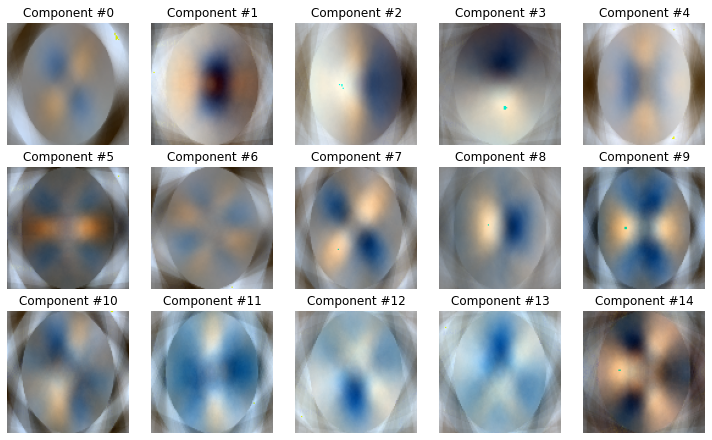

In [38]:
fig, axes = plt.subplots(3,5, figsize = (10,6),constrained_layout=True)
for i, ax in enumerate(axes.ravel()):
    img = pca.components_[i].reshape(100,100,3)
    img = (img - np.amax(img))/(np.amax(img)-np.amin(img))
    img *= 255
    ax.imshow(img.astype(np.uint8))
    ax.set_title('Component #%i' %(i))
    ax.axis('off')

Using this components we could reconstruct the images.

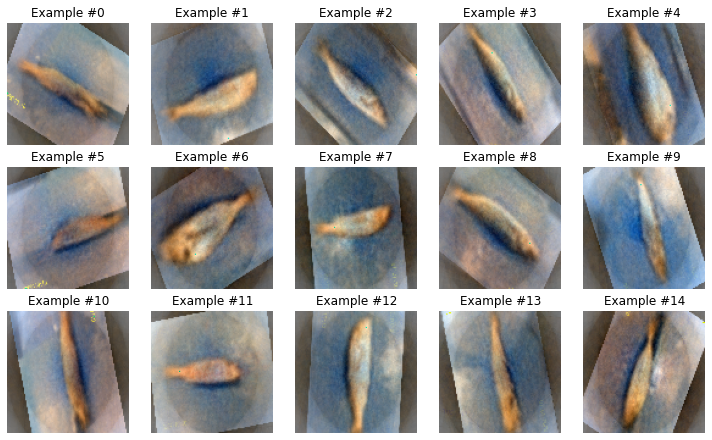

In [39]:
x_test_recovered = pca.inverse_transform(x_test_reduced)

fig, axes = plt.subplots(3,5, figsize = (10,6),constrained_layout=True)
plt.title("Examples after PCA")
for i, ax in enumerate(axes.ravel()):
    img = x_test_recovered[i].reshape(100,100,3)
    img = (img - np.amax(img))/(np.amax(img)-np.amin(img))
    img *= 255
    ax.imshow(img.astype(np.uint8))
    ax.set_title(f"Example #{i}")
    ax.axis('off')

## PCA + FFNN

Now that we reduced the number of dimensions of the input to 1012 we can use simpler method to classify the fish species. For example we could use a FFNN

In [46]:
input_shapePCA = (1012)
modelPCA = tf.keras.models.Sequential([
    tf.keras.Input(shape=input_shapePCA),
    tf.keras.layers.Dense(256, activation='elu'),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
], name="FFNN_after_PCA")

modelPCA.summary()

modelPCA.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10,restore_best_weights=True)

MAX_EPOCHS = 50
history = modelPCA.fit(
    x_train_reduced, y_train,
    epochs = MAX_EPOCHS,
    validation_data = (x_val_reduced, y_val),
    callbacks = callback
)

Model: "FFNN_after_PCA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 256)               259328    
_________________________________________________________________
dense_42 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_43 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)            

71/71 [==============================] - 0s 2ms/step - loss: 0.2470 - accuracy: 0.9316

On the test sample, the model we trained, has an accuracy of 93.16 %


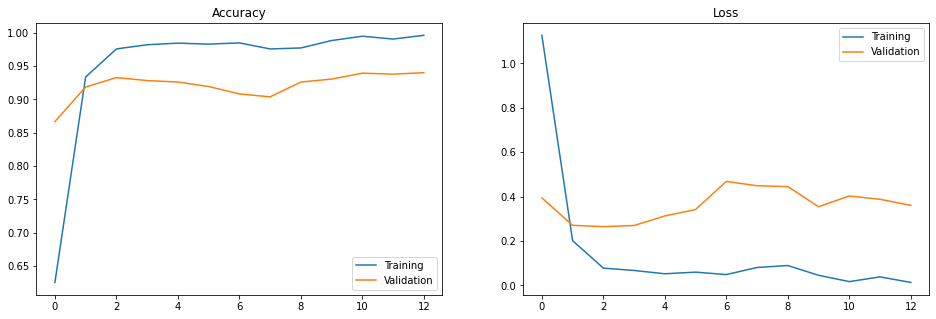

In [47]:
# Print accuracy and loss plots
_ , ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(history.history['accuracy'], label = 'Training')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].legend()
ax[1].set_title('Loss')

plt.plot()

# Evaluate the model on test sample
performance = modelPCA.evaluate(x_test_reduced,y_test)[1]
print(f"\nOn the test sample, the model we trained, has an accuracy of {round(performance*100,2)} %")

As expected the result is a model which is worse than the complete CNN, but on the other hand it took only a few seconds to be trained instead of the 10-15 minutes of the CNN

## Decision Tree

A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether variable is < or > than a particoular value), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.

<img src="https://miro.medium.com/max/2000/1*jojTznh4HOX_8cGw_04ODA.png" width="300">

The algorithm to create a decisional tree is called CART and in the ends the predicted value is

$$
\hat y = \sum_{m=1}^M c_m I(\underline x \in R_m),\qquad \text{with} \quad I(\underline x \in R_m) = \begin{cases} 1 \qquad & \text{if} \quad x \in R_m\\ 0 & \text{otherwise} \\ \end{cases}
$$

$M$, $c_m$ and the zones $R_m$ are chosen by minimizing the cost function

$$
J(j,s)=\frac{N_1^{(n)}}{N^{(n)}}Q_1 + \frac{N_2^{(n)}}{N^{(n)}}Q_2
$$

where $N_i^{(n)}$ is the number of inputs in $R_i$ and $Q_i$ are impurities and are defined

$$
Q_i=-\sum_{k=1}^K \hat p _{ik} \log_2 \hat p _{ik}
$$

with $\hat p _{ik}$ the probability that inside region $R_i$ the observation in in the class $k$.

A decisional tree model requires two parameters to be tuned in order to obtain a better model. The parameters are the maximum depth of the tree and minimum number of samples in a leaf. We explored different possibilities and in the end we chose the best one.

In [106]:
MIN_SAMPLES_SPLIT = [2,4,6,8,10]
MAX_DEPTH = [5,10,15,20,25]

result_train = np.zeros((5,5))
result_test = np.zeros((5,5))
for i in range(len(MIN_SAMPLES_SPLIT)):
    for j in range(len(MAX_DEPTH)):
        classifier = tree.DecisionTreeClassifier(criterion="entropy",
                                        min_samples_split=MIN_SAMPLES_SPLIT[i],
                                        max_depth=MAX_DEPTH[j])
        classifier = classifier.fit(x_train_reduced, y_train)
    
        result_train[i][j]=accuracy_score(y_train, classifier.predict(x_train_reduced))
        result_test[i][j]=accuracy_score(y_test, classifier.predict(x_test_reduced))

[]

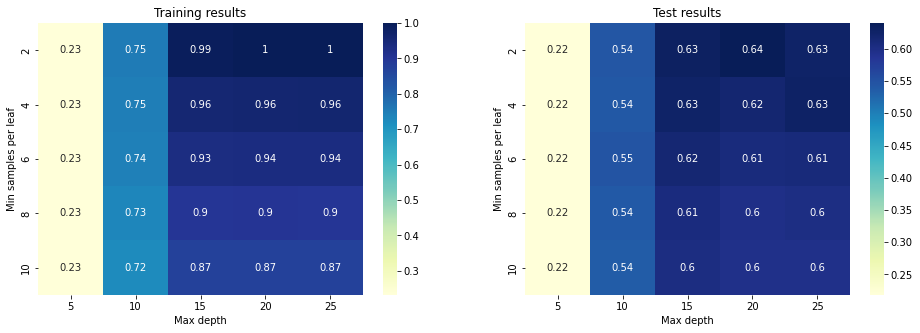

In [141]:
# Print accuracy and loss plots
_ , ax = plt.subplots(1,2,figsize=(16,5))

train_pd = pd.DataFrame(result_train, columns=MAX_DEPTH, index=MIN_SAMPLES_SPLIT)
g1 = sns.heatmap(train_pd,cmap="YlGnBu",ax=ax[0],annot=True)
g1.set_xlabel('Max depth')
g1.set_ylabel('Min samples per leaf')
g1.set_title('Training results')

test_pd = pd.DataFrame(result_test, columns=MAX_DEPTH, index=MIN_SAMPLES_SPLIT)
g2 = sns.heatmap(test_pd,cmap="YlGnBu", ax=ax[1],annot=True)
g2.set_xlabel('Max depth')
g2.set_ylabel('Min samples per leaf')
g2.set_title('Test results')

plt.plot()

In [148]:
classifier = tree.DecisionTreeClassifier(criterion="entropy",
                                        min_samples_split=2,
                                        max_depth=20)
classifier = classifier.fit(x_train_reduced, y_train)

print(f'Training accuracy: {round(accuracy_score(y_train, classifier.predict(x_train_reduced))*100,2)} %')
print(f'Test accuracy: {round(accuracy_score(y_test, classifier.predict(x_test_reduced))*100,2)} %')

Training accuracy: 100.0 %
Test accuracy: 63.56 %


## Random forest

The random forest algorithm that creates many decisional trees and the output is just the mean of all the decisional tree. This algorithm works thanks to the law of large numbers.

<img src="https://i.stack.imgur.com/iY55n.jpg" width="300">

Here we create 100 decisional tree

In [49]:
rnd_forest = RandomForestClassifier(
    criterion = 'entropy',
    min_samples_split = 2,
    max_depth = 25,
    max_features = 1.0,
    ccp_alpha = 1e-4,
)
rnd_forest = rnd_forest.fit(x_train_reduced, y_train)

print(f'Training accuracy: {round(accuracy_score(y_train, rnd_forest.predict(x_train_reduced))*100,2)} %')
print(f'Test accuracy: {round(accuracy_score(y_test, rnd_forest.predict(x_test_reduced))*100,2)} %')

Training accuracy: 99.93 %
Test accuracy: 53.07 %


## LDA

Linear Discriminant Analysis (LDA) is a linear classification method that compute a discriminatn function $\delta_k(x)$ and for every input $x$ the class is the one which has a greater value for $\delta_k(x)$.

Given a set of classes $G = 1,2,...,K$, in order to find the discriminant function we use the Bayes theorem:

$$
P(G=k|X=x) = \frac{P(X=x|G=k) P(G=k)}{\sum_{l=1}^{K} P(X=x|G=l)P(G=l) } = \frac{f_k(x) \pi_k}{\sum_{l=1}^{K}f_l(x)\pi_l},
$$

where $f_k(x)$ is the distribution of $x$ in the class $G=k$, and $\pi_k$ is the a-priori probability of the class k. Assuming that $f_k(x)$ is a multivariate gaussian distribution with covariance matrix $\Sigma$, we consider the logarithm of $P(G=k|X=x) / P(G=l|X=x)$ so that we do not need to explicitly evaluate the normalization

$$
\log\frac{P(G=k|X=x)}{P(G=l|X=x)} = \dots = \log\frac{\pi_k}{\pi_l} - \frac{1}{2}(\mu_k + \mu_l)\Sigma^{-1}(\mu_k - \mu_l) + x^T \Sigma^{-1} (\mu_k - \mu_l)
$$

We find a linear relation in $x$, that can be re-written in terms of the discriminant function
$$
\delta_k(x) = x^T \Sigma^{-1} \mu_k - \frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k + \log\pi_k,
$$
and
$$
G(x) = \underset{k}{\text{argmax}} [\delta_k(x)]
$$

In [50]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_reduced, np.argmax(y_train, axis=1))

print(f'Training accuracy: {round(accuracy_score(np.argmax(y_train, axis = 1), lda.predict(x_train_reduced))*100,2)} %')
print(f'Test accuracy: {round(accuracy_score(np.argmax(y_test, axis = 1), lda.predict(x_test_reduced))*100,2)} %')

Training accuracy: 99.07 %
Test accuracy: 93.07 %


## Logistic regression

The logistic regression is a classification model, in which we try to describe the probabilities that an output $y_i$, knowing that it comes from an input $\underline x _i$, belongs to a class $k$. We model $p_k(y_i|\underline x _i, \underline \beta)\equiv p_k(\underline x _i)$ in this way

$$
p_k(\underline x)=
\begin{cases}
p_1(\underline x) &= \frac{e^{\beta_{10}+\underline \beta _1^T \underline x}}{1+\sum_{l=1}^{K-1}e^{\beta_{l0}+\underline \beta _l^T \underline x}} \\
p_2(\underline x) &= \frac{e^{\beta_{20}+\underline \beta _1^T \underline x}}{1+\sum_{l=1}^{K-1}e^{\beta_{l0}+\underline \beta _l^T \underline x}} \\
\dots \\
p_K(\underline x) &= \frac{1}{1+\sum_{l=1}^{K-1}e^{\beta_{l0}+\underline \beta _l^T \underline x}} \\
\end{cases}
$$

and the parameters $\underline \beta$ are found using the Maximum Likelihood Estimation function, that is

$$
\hat \beta = \underset{\underline \beta}{\text{argmax}}\quad \mathcal{P}(D|\underline \beta)
$$

where $\mathcal{P}(D|\underline \beta)$ represent the probability of observing the dataset D given the parameters $\underline \beta$

In [51]:
logistic = LogisticRegression(solver='liblinear')
logistic.fit(x_train_reduced, np.argmax(y_train, axis=1))

print(f'Training accuracy: {round(accuracy_score(np.argmax(y_train, axis = 1), logistic.predict(x_train_reduced))*100,2)} %')
print(f'Test accuracy: {round(accuracy_score(np.argmax(y_test, axis = 1), logistic.predict(x_test_reduced))*100,2)} %')

Training accuracy: 100.0 %
Test accuracy: 93.07 %


## Conclusion

Here we summarize our result

|                               | **Training accuracy** | **Test Accuracy** |
|-------------------------------|-----------------------|-------------------|
| **CNN**                       |      99.70 %          |    97.33 %        |
| **PCA + FFNN**                |      99.41 %          |    93.16 %        |
| **PCA + Decisional Tree**     |      100.00 %         |    63.56 %        |
| **PCA + Random Forest**       |      99.93 %          |    53.07 %        |
| **PCA + LDA**                 |      99.07 %          |    93.07 %        |
| **PCA + Logistic Regression** |      100.00 %         |    93.07 %        |

The best model is, as we could have expected, the convolutional neural network since it is the most complex one and it has been developed with the scope of recognising patterns inside strongly correlated input data, such as images. 

When analyzing these data we should also take into account that all the methods that involve PCA were applied after reducing the image size to 100 x 100 due to my laptop poor performance. It would be interesting to run the code of a more powerful machine and see how the resolution affects the performance of the algorithms. Anyway it is interesting to note that the dimensional reduction really helps to speed up the algorithms. In particoular to train a CNN requires more or less 15 minutes, so in order to tune all the different parameters, such as the learning rate, one has to spend a long time waiting for the network's training. On the other hand applying the PCA requires ~5 minutes and after that the training of the FFNN lasts only few seconds, so one has the opportunity to better explore the influence of different parameters.

## Bibliography

[A Large-Scale Dataset for Fish Segmentation and Classification](https://ieeexplore.ieee.org/abstract/document/9259867)<br>
**Authors:** O. Ulucan, D. Karakaya, M. Turkan<br>
**University:** Department of Electrical and Electronics Engineering, Izmir University of Economics, Izmir, Turkey<br>
**Corresponding author:** M. Turkan<br>
**Contact Information:** [mehmet.turkan@ieu.edu.tr](mailto:mehmet.turkan@ieu.edu.tr)